# Predictive Maintenance

Tutorial para un dataset real.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset

El dataset con el que vamos a trabajar es publicado por la NASA [[3](#References)], consiste en simulaciones sobre la degradación de motors de aviones bajo diferentes combinaciones de condiciones de trabajo.

**La tarea principal es predecir el momento en el que el motor va a fallar antes de que suceda.**

<div align="center">
  <img src="images/airbus-turbofan.jpg" height="50%" style="max-width: 50%">
</div>


In [5]:
!mkdir data
!wget https://ti.arc.nasa.gov/c/6/ -O data/CMAPSSData.zip
!unzip -o data/CMAPSSData.zip -d data

--2022-07-22 07:12:47--  https://ti.arc.nasa.gov/c/6/
Resolviendo ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66
Conectando con ti.arc.nasa.gov (ti.arc.nasa.gov)[128.102.105.66]:443... conectado.
Petición HTTP enviada, esperando respuesta... 301 Moved Permanently
Localización: https://www.nasa.gov/intelligent-systems-division [siguiendo]
--2022-07-22 07:12:48--  https://www.nasa.gov/intelligent-systems-division
Resolviendo www.nasa.gov (www.nasa.gov)... 13.33.232.46, 13.33.232.10, 13.33.232.28, ...
Conectando con www.nasa.gov (www.nasa.gov)[13.33.232.46]:443... conectado.
Petición HTTP enviada, esperando respuesta... 301 Moved Permanently
Localización: //www.nasa.gov/intelligent-systems-division/ [siguiendo]
--2022-07-22 07:12:49--  https://www.nasa.gov/intelligent-systems-division/
Reutilizando la conexión con www.nasa.gov:443.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 33609 (33K) [text/html]
Grabando a: «data/CMAPSSData.zip»

data/CMAPSSData.zip 100%[=======

In [7]:
# this converts the encoding
#!iconv -f ISO-8859-1 -t UTF-8//TRANSLIT data/readme.txt > data/readme_enc.txt
!cat  data/readme.txt

Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX 
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX 
Fault Modes: TWO (HPC Degradation, Fan Degradation)



Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine � i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. Th

In [8]:
# train and test data are simple space separated values
!head -5 data/train_FD001.txt

1 1 -0.0007 -0.0004 100.0 518.67 641.82 1589.70 1400.60 14.62 21.61 554.36 2388.06 9046.19 1.30 47.47 521.66 2388.02 8138.62 8.4195 0.03 392 2388 100.00 39.06 23.4190  
1 2 0.0019 -0.0003 100.0 518.67 642.15 1591.82 1403.14 14.62 21.61 553.75 2388.04 9044.07 1.30 47.49 522.28 2388.07 8131.49 8.4318 0.03 392 2388 100.00 39.00 23.4236  
1 3 -0.0043 0.0003 100.0 518.67 642.35 1587.99 1404.20 14.62 21.61 554.26 2388.08 9052.94 1.30 47.27 522.42 2388.03 8133.23 8.4178 0.03 390 2388 100.00 38.95 23.3442  
1 4 0.0007 0.0000 100.0 518.67 642.35 1582.79 1401.87 14.62 21.61 554.45 2388.11 9049.48 1.30 47.13 522.86 2388.08 8133.83 8.3682 0.03 392 2388 100.00 38.88 23.3739  
1 5 -0.0019 -0.0002 100.0 518.67 642.37 1582.85 1406.22 14.62 21.61 554.00 2388.06 9055.15 1.30 47.28 522.19 2388.04 8133.80 8.4294 0.03 393 2388 100.00 38.90 23.4044  


In [9]:
# the test truth is given as the number of steps to failure
# for each engine run in the test set (100 in total)
!head -5 data/RUL_FD001.txt

112 
98 
69 
82 
91 


In [12]:
# load data (only gonna use FD001 dataset)
train_df = pd.read_csv('data/train_FD001.txt', sep=" ", header=None)
test_df  = pd.read_csv('data/test_FD001.txt', sep=" ", header=None)
print("train shape: ", train_df.shape, "test shape: ", test_df.shape)
# lets have a look at basic descriptive statistics
train_df.describe()

train shape:  (20631, 28) test shape:  (13096, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


In [13]:
# we will remove columns 26 and 27 because of the NaNs
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
print("train shape: ", train_df.shape, "test shape: ", test_df.shape)

train shape:  (20631, 26) test shape:  (13096, 26)


In [14]:
# the files did not contain headers
# we can create them based on the documentation
target_var = ['target_RUL']
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
column_names = index_columns_names + op_settings_columns + sensor_columns
print(column_names)

['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_20', 'Sensor_21']


In [15]:
# name columns
train_df.columns = column_names
test_df.columns = column_names

# now the dataset looks better, e.g. the first unit
train_df[train_df.UnitNumber == 1].head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Remaining Useful Life (RUL)

Los datos de entrenamiento consisten en series temporales de los sensores del motor para cada ciclo (es decir, paso de tiempo) hasta el fallo.

Así, la vida útil restante (RUL), es decir, el tiempo hasta que el motor se rompa, puede calcularse basándose en el ciclo máximo de cada unidad presente en el conjunto de entrenamiento.


In [16]:
# find the last cycle per unit number
max_cycle = train_df.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle.columns = ['UnitNumber', 'MaxOfCycle']
# merge the max cycle back into the original frame
train_df = train_df.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')
# calculate RUL for each row
target_RUL = train_df["MaxOfCycle"] - train_df["Cycle"]
# add columns and remove MaxOfCycle
train_df["target_RUL"] = target_RUL
train_df = train_df.drop("MaxOfCycle", axis=1)
# check that it worked for unit 1
train_df[train_df.UnitNumber == 1].head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,target_RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


Los datos de prueba no corresponden a la ejecución hasta el fallo como se comenta en la documentación del conjunto de datos, el RUL en el último paso se proporciona en cambio en un archivo adicional.

In [17]:
# get truth RUL
truth_df = pd.read_csv('data/RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
# UnitNumber based
truth_df.columns = ["RUL_after_last"]
truth_df['UnitNumber'] =  truth_df.index + 1
# find the last cycle per unit number in test set
max_cycle = test_df.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle.columns = ['UnitNumber', 'MaxOfCycle']
max_cycle['MaxOfCycle'] = max_cycle['MaxOfCycle'] + truth_df["RUL_after_last"]
# merge the max cycle back into the original frame
test_df = test_df.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')
# calculate RUL for each row
target_RUL = test_df["MaxOfCycle"] - test_df["Cycle"]
# add columns and remove MaxOfCycle
test_df["target_RUL"] = target_RUL
test_df = test_df.drop("MaxOfCycle", axis=1)
# check that it worked for unit 1
test_df[test_df.UnitNumber == 1].head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,target_RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


### Defining the Problem


**El primer paso antes de empezar con ML (o con cualquier problema) es entender bien la tarea que tenemos entre manos.**

El mantenimiento predictivo consiste en tener predicciones precisas (basadas en sensores o rendimientos) de cuándo va a fallar una máquina o una instalación industrial y cómo programar el costoso mantenimiento de forma inteligente y reducir los costes de explotación.

Las definiciones de problemas más comunes para el mantenimiento predictivo son: 

- Regresión (**incluida aquí**): Predecir la vida útil restante (RUL) o el tiempo hasta el fallo (TTF).
- Clasificación binaria (**incluida aquí**): Predecir si un activo va a fallar en un plazo determinado (por ejemplo, días).
- Clasificación multiclase (**no incluida aquí**): Predecir si un activo fallará en diferentes ventanas de tiempo o debido a diferentes modelos de fallo.


Estas técnicas son las que también se utilizan para la previsión general de series temporales pero en el momento de la aplicación no tenemos acceso al valor objetivo en el paso de tiempo actual o paso de tiempo anterior.



### Feature Exploration

Independientemente del problema elegido, siempre se recomienda explorar de forma interactiva las variables a considerar en el problema de modelización predictiva.

Es importante no sólo considerar los datos disponibles en el conjunto de entrenamiento, sino también los que se esperan en el
o entorno de producción. Alternativamente podemos incurrir en:

- **fuga de objetivos**: utilizar información que tiene poder predictivo como entrada del modelo durante el entrenamiento pero que no estará disponible en producción o en los datos reales.
- **desajuste del dominio**: si los datos de entrenamiento y de prueba/producción son diferentes, los modelos entrenados podrían no funcionar bien en en el escenario de los datos reales.

In [18]:
# we will consider all features except the UnitNumber and the target
basic_features = train_df.columns.difference(["UnitNumber","target_RUL"])
print("basic_features: ",basic_features)

basic_features:  Index(['Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 'Sensor_1',
       'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14',
       'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19',
       'Sensor_2', 'Sensor_20', 'Sensor_21', 'Sensor_3', 'Sensor_4',
       'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9'],
      dtype='object')


#### Exercise: Plot the Sensor Data for given Unit

Para una unidad determinada del conjunto de entrenamiento, traza la serie temporal de algunos de los datos de los sensores.

In [ ]:
# space for exercise solution

#### Exercise: Compare the Distribution of Variables in the Train and Test sets

Compare gráficamente la distribución de algunas de las variables de entrada (por ejemplo, "Ciclo", "Op_Setting_1" o datos de los sensores) para los conjuntos de entrenamiento y prueba.

In [ ]:
# space for exercise solution

#### Exercise: Compare the Distrubution of the Target in the Train and Test sets

Compare gráficamente la distribución de la RUL objetivo en los conjuntos de entrenamiento y prueba.
¿Afectará esto al entrenamiento? ¿Cómo podría evitarse? 

In [ ]:
# space for exercise solution

### Feature Transformations and Engineering

Otro paso importante, sobre todo cuando se trata de la mayoría de las técnicas distintas del aprendizaje profundo, es el *preprocesamiento/escalado de características* e *ingeniería de características*.

El preprocesamiento/escalado de características puede facilitar el entrenamiento del modelo mediante escalado de las características a valores adimensionales basados en las propiedades del conjunto de datos.

La ingeniería de rasgos, la definición de nuevas variables basadas de las disponibles, es especialmente importante para los datos de series temporales cuando queremos hacer una predicción cuando queremos hacer una predicción para cada paso de tiempo, como es el caso de todos los problemas considerados en este cuaderno.




In [19]:
from sklearn import preprocessing

# we will use the Standard Scaler
scaler = preprocessing.StandardScaler()

features = basic_features
X_unscaled = train_df[features].astype('float64')
X = pd.DataFrame(scaler.fit_transform(X_unscaled),
                 columns = features,
                 index = train_df.index)
y = train_df["target_RUL"]

X.describe()

,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,...,Sensor_2,Sensor_20,Sensor_21,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9
count,2.063100e+04,2.063100e+04,2.063100e+04,20631.0,20631.0,20631.0,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,...,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04
mean,-8.816778e-17,1.377622e-18,-2.720802e-17,0.0,0.0,0.0,-2.937089e-15,-1.199702e-13,3.493855e-13,3.061075e-15,...,6.410348e-14,4.156146e-14,2.402296e-14,-4.959437e-14,9.285169e-16,-1.776357e-15,-6.469426e-12,-3.161641e-14,1.008249e-12,-4.185765e-14
std,1.000024e+00,1.000024e+00,1.000024e+00,0.0,0.0,0.0,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,...,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,0.000000e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,-1.565170e+00,-3.973523e+00,-2.055419e+00,0.0,0.0,0.0,-2.587860e+00,-3.692663e+00,-3.005574e+00,-2.296780e+00,...,-2.941625e+00,-3.741634e+00,-3.653688e+00,-3.177804e+00,-2.964737e+00,-1.776357e-15,-7.057993e+00,-3.974497e+00,-2.770375e+00,-1.970486e+00
25%,-8.247448e-01,-6.817340e-01,-6.904875e-01,0.0,0.0,0.0,-7.157686e-01,-6.148450e-01,-7.807925e-01,-5.508429e-01,...,-7.118085e-01,-6.432961e-01,-6.273114e-01,-6.953381e-01,-7.303888e-01,-1.776357e-15,1.416833e-01,-6.301317e-01,-6.572157e-01,-5.498936e-01
50%,-6.980124e-02,4.055368e-03,-8.021809e-03,0.0,0.0,0.0,-1.166993e-01,9.020580e-02,-8.554830e-02,-1.684195e-01,...,-8.186036e-02,7.596096e-02,7.570228e-02,-6.901297e-02,-9.930481e-02,-1.776357e-15,1.416833e-01,8.167571e-02,-9.370652e-02,-2.075387e-01
75%,6.851423e-01,6.898448e-01,1.015677e+00,0.0,0.0,0.0,5.946956e-01,7.274632e-01,6.096959e-01,2.389047e-01,...,6.380804e-01,7.398906e-01,7.122022e-01,6.290786e-01,6.245530e-01,-1.776357e-15,1.416833e-01,7.256920e-01,6.106800e-01,1.891583e-01
max,3.675880e+00,3.981634e+00,2.039375e+00,0.0,0.0,0.0,3.702368e+00,2.666353e+00,6.449748e+00,7.861686e+00,...,3.697829e+00,3.395609e+00,3.036489e+00,4.303846e+00,3.617202e+00,-1.776357e-15,1.416833e-01,3.041891e+00,6.527526e+00,8.121740e+00


In [20]:
X_test_unscaled = test_df[features].astype('float64')
X_test = pd.DataFrame(scaler.transform(X_test_unscaled),
                      columns = features,
                      index = test_df.index)
y_test = test_df["target_RUL"]

X_test.describe()

,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,...,Sensor_2,Sensor_20,Sensor_21,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9
count,13096.000000,13096.000000,13096.000000,13096.0,13096.0,13096.0,13096.000000,13096.000000,13096.000000,13096.000000,...,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.000000,13096.000000,13096.000000
mean,-0.464165,-0.001056,0.006439,0.0,0.0,0.0,-0.467888,0.453204,-0.349397,-0.251886,...,-0.411658,0.421766,0.425294,-0.395354,-0.466471,-1.776357e-15,-0.073823,0.440430,-0.361875,-0.309549
std,0.770300,1.007052,1.003329,0.0,0.0,0.0,0.733550,0.758779,0.791665,0.534114,...,0.801733,0.783884,0.777105,0.816062,0.743114,0.000000e+00,1.226886,0.769753,0.809224,0.517892
min,-1.565170,-3.744927,-2.055419,0.0,0.0,0.0,-2.775070,-2.757115,-2.866525,-1.848042,...,-3.101612,-2.801067,-3.273082,-3.504015,-2.726970,-1.776357e-15,-7.057993,-2.810748,-2.911252,-1.843687
25%,-1.100590,-0.681734,-0.690488,0.0,0.0,0.0,-1.015303,-0.045381,-0.919841,-0.599858,...,-0.966788,-0.090021,-0.074878,-0.966093,-0.998155,-1.776357e-15,0.141683,-0.065205,-0.938970,-0.644087
50%,-0.577936,0.004055,-0.008022,0.0,0.0,0.0,-0.491118,0.496966,-0.363646,-0.281128,...,-0.441831,0.463253,0.457233,-0.413166,-0.499288,-1.776357e-15,0.141683,0.488423,-0.375461,-0.358791
75%,0.060862,0.689845,1.015677,0.0,0.0,0.0,-0.004374,0.998637,0.192549,0.031835,...,0.118123,0.961200,0.959781,0.136908,0.012913,-1.776357e-15,0.141683,0.985558,0.188048,-0.051305
max,2.819310,3.570160,2.380608,0.0,0.0,0.0,2.691438,3.181582,3.112575,4.022249,...,3.237866,3.284954,3.253583,2.777178,2.713908,-1.776357e-15,0.141683,2.793323,2.864717,4.066011


### RUL Prediction as a Regression Task

**¿Cuántos ciclos más durará un motor en servicio antes de fallar?

La tarea de predecir la vida útil restante (RUL) puede considerarse una tarea de regresión en el contexto del aprendizaje automático. La RUL también puede denominarse Tiempo hasta el fallo (TTF).


El objetivo en un problema de regresión es encontrar una función $f_R(\boldsymbol{x})$ que se aproxime al verdadero objetivo $y$. El objetivo en este problema será el RUL, mientras que $\boldsymbol{x}$ serán las características de entrada (por ejemplo, las lecturas de los sensores).

Para medir la bondad de nuestra función de regresión, necesitamos definir una función de *loss*. 

Consideraremos el error medio cuadrático:
$$ \textrm{MSE} = \sum_{i=1}^{n} (y - f_R(\boldsymbol{x}))^2$$

que es una de las funciones de perdida más comunes utilizadas para la regresión. Dependiendo del problema, otras definiciones de pérdidas pueden ser más beneficiosas.

#### Baseline and Feature Importance

A veces es útil entrenar un modelo simple para la tarea en cuestión para obtener un rendimiento de referencia. Un bosque aleatorio tiene la ventaja de que también puede proporcionar una lista de la importancia relativa de las de las diferentes características.

In [21]:
from sklearn import ensemble

rf = ensemble.RandomForestRegressor()
simple_rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15)
simple_rf.fit(X, y)

RandomForestRegressor(max_depth=15, n_estimators=200)

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = simple_rf.predict(X)
print("[Train] Simple RF Mean Squared Error: ", mean_squared_error(y, y_pred))
print("[Train] Simple RF Mean Absolute Error: ", mean_absolute_error(y, y_pred))
print("[Train] Simple RF r-squared: ", r2_score(y, y_pred))

[Train] Simple RF Mean Squared Error:  364.0878084982622
[Train] Simple RF Mean Absolute Error:  13.557381385284758
[Train] Simple RF r-squared:  0.9232588284823311


In [23]:
y_test_pred = simple_rf.predict(X_test)
print("[Test] Simple RF Mean Squared Error: ", mean_squared_error(y_test, y_test_pred))
print("[Test] Simple RF Mean Absolute Error: ", mean_absolute_error(y_test, y_test_pred))
print("[Test] Simple RF r-squared: ", r2_score(y_test, y_test_pred))

[Test] Simple RF Mean Squared Error:  1703.7309677498015
[Test] Simple RF Mean Absolute Error:  31.38214960636339
[Test] Simple RF r-squared:  0.5101952815104074


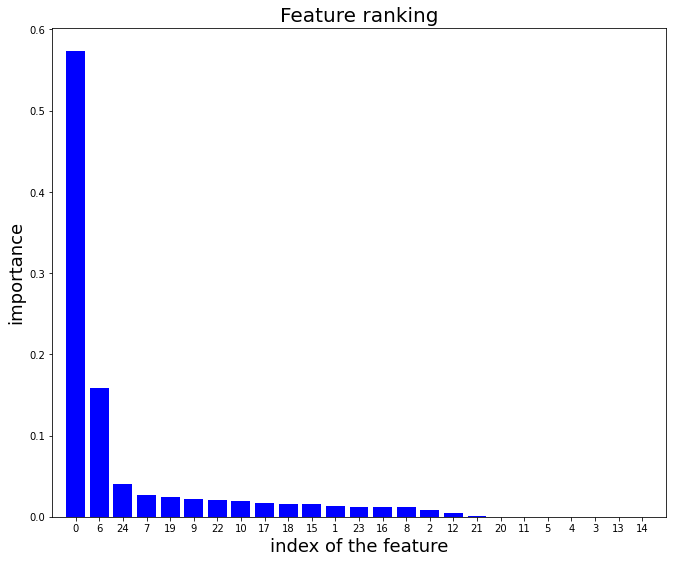

Cycle        0.573655
Sensor_11    0.157960
Sensor_9     0.040383
Sensor_12    0.027339
Sensor_4     0.024782
Sensor_14    0.022345
Sensor_7     0.020471
Sensor_15    0.019652
Sensor_21    0.017389
Sensor_3     0.016208
dtype: float64


In [24]:
# graph feature importance
import matplotlib.pyplot as plt
importances = simple_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns    
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), indices) #feature_names, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()
# list feature importance
important_features = pd.Series(data=simple_rf.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features.head(10))

#### Cross Validation and Hyper-Parameters

Mediante la validación cruzada y la búsqueda de hiperparámetros, podemos podemos intentar obtener un mejor modelo de regresión basado en RandomForest.

In [25]:
from sklearn.model_selection import GroupKFold, GridSearchCV

rf = ensemble.RandomForestRegressor(n_estimators=100)

# to avoid having same UnitNumber in both sets
cv = GroupKFold(5)

param_grid = { "min_samples_leaf" : [2, 10, 25, 50, 100],
               "max_depth" : [7, 8, 9, 10, 11, 12]}

optimized_rf = GridSearchCV(estimator=rf,
                            cv = cv,
                            param_grid=param_grid,
                            scoring='neg_mean_squared_error',
                            verbose = 1,
                            n_jobs = -1)

optimized_rf.fit(X, y, groups = train_df.UnitNumber)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=GroupKFold(n_splits=5), estimator=RandomForestRegressor(),
             n_jobs=-1,
             param_grid={'max_depth': [7, 8, 9, 10, 11, 12],
                         'min_samples_leaf': [2, 10, 25, 50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [27]:
y_test_pred = optimized_rf.predict(X_test)
print("[Test] Optimized RF Mean Squared Error: ", mean_squared_error(y_test, y_test_pred))
print("[Test] Optimized RF Mean Absolute Error: ", mean_absolute_error(y_test, y_test_pred))
print("[Test] Optimized RF r-squared: ", r2_score(y_test, y_test_pred))

[Test] Optimized RF Mean Squared Error:  1666.8261608175499
[Test] Optimized RF Mean Absolute Error:  30.80559957282142
[Test] Optimized RF r-squared:  0.5208050250160022


#### Other Models: Gradient Boosting

Gradient Boosted es uno de los modelo de mejor rendimiento para una gran variedad de tareas, veamos si pueden aplicarse también a este conjunto de datos.


In [28]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()

# to avoid having same UnitNumber in both sets
cv = GroupKFold(5)

param_grid = { "alpha" : [.75, .9],
               "n_estimators" : [500],
               "learning_rate" :  [.01],
                "max_depth" : [4, 5, 6]
             }

optimized_gb= GridSearchCV(estimator=gb,
                            cv = cv,
                            param_grid=param_grid,
                            scoring='neg_mean_squared_error',
                            verbose = 1,
                            n_jobs = -1)

optimized_gb.fit(X, y, groups = train_df.UnitNumber)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=GroupKFold(n_splits=5), estimator=GradientBoostingRegressor(),
             n_jobs=-1,
             param_grid={'alpha': [0.75, 0.9], 'learning_rate': [0.01],
                         'max_depth': [4, 5, 6], 'n_estimators': [500]},
             scoring='neg_mean_squared_error', verbose=1)

In [29]:
y_test_pred = optimized_gb.predict(X_test)
print("[Test] Optimized GB Mean Squared Error: ", mean_squared_error(y_test, y_test_pred))
print("[Test] Optimized GB Mean Absolute Error: ", mean_absolute_error(y_test, y_test_pred))
print("[Test] Optimized GB r-squared: ", r2_score(y_test, y_test_pred))

[Test] Optimized GB Mean Squared Error:  1654.6433543808776
[Test] Optimized GB Mean Absolute Error:  30.651624989299602
[Test] Optimized GB r-squared:  0.52430745362127


#### Exercise: Train Another Cross Validated Model

Basándose en los ejemplos anteriores, utilice la validación cruzada para encontrar un buen conjunto de hiperparámetros y comparar en el conjunto de datos de prueba otro modelo de regresión de scikit-learn ([ver documentación](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)), por ejemplo elegir entre:
1. `sklearn.svm.SVR`: [Epsilon-Regresión de Vectores de Soporte](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)
2. `sklearn.neural_network.MLPRegressor` : [Perceptrón multicapa](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)
3. **Pista avanzada**: utiliza `GradientBoostingRegressor` pero añade algunas características de ingeniería para intentar mejorar el resultado anterior

In [ ]:
# space for the exercise solution

### Predict Failures using Classification

**¿Fallará la unidad en un plazo determinado (es decir, en un número de ciclos)?

Esto puede considerarse un problema de clasificación, donde el objetivo es si la unidad fallará dentro de los próximos $n$ pasos de tiempo (por ejemplo, 15 ciclos).

El objetivo en un problema de clasificación (suave) es encontrar una función $f_C(\boldsymbol{x})$ que aproxime las probabilidades de pertenecer a un conjunto de clases o categorías $y$. El objetivo en este problema será si el motor fallará en los próximos 15 pasos de tiempo, mientras que $\boldsymbol{x}$ serán las características de entrada (por ejemplo, las lecturas de los sensores).

Para medir la bondad de nuestra función de clasificación, necesitamos definir una función de perdida. Consideraremos la entropía cruzada binaria:
$$ \textrm{BCE} = \sum_{i=1}^{n} (y \log \left(f_C(\boldsymbol{x})\right) - (1-y) y \log \left(1-f_C(\boldsymbol{x}) \right )$$
que es una de las pérdidas más comunes utilizadas para la clasificación binaria binario, y podría extenderse también al problema de multiclase/multietiqueta.


In [30]:
from sklearn.model_selection import train_test_split

# we can keep the same input features, we have only to compute the
# new target (we will only use the train set for classification)
cycles = 15
train_df['Target_15_Cycles'] = np.where(train_df['target_RUL'] <= cycles, 1, 0 )

y_clf = train_df["Target_15_Cycles"]

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X, y_clf, test_size=0.2, random_state=1234)

train_df.tail()

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,target_RUL,Target_15_Cycles
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,1
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,1
20630,100,200,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,...,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,0,1


#### Gradient Boosting for Classification

De forma similar a lo que se hizo para el problema de regresión y dado el buen rendimiento observado para el modelo Gradient Boosting, entrenaremos un modelo de refuerzo de gradiente para la clasificación.


In [31]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()

# to avoid having same UnitNumber in both sets
cv = KFold(3)

param_grid = { "n_estimators" : [500],
               "learning_rate" :  [.01],
                "max_depth" : [6]
             }

optimized_gb_clf = GridSearchCV(estimator=gb_clf,
                            cv = cv,
                            param_grid=param_grid,
                            verbose = 1,
                            n_jobs = -1)

optimized_gb_clf.fit(X_clf_train, y_clf_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [6],
                         'n_estimators': [500]},
             verbose=1)

In [32]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report

y_test_clf_proba = optimized_gb_clf.predict_proba(X_clf_test)[:, 1]
y_test_clf_pred = optimized_gb_clf.predict(X_clf_test)

print("Confusion Matrix:")
print(confusion_matrix(y_clf_test,y_test_clf_pred))
print("Gradient Boosting Classifier Accuracy: "+"{:.1%}".format(accuracy_score(y_clf_test,y_test_clf_pred)));
print("Gradient Boosting Classifier Precision: "+"{:.1%}".format(precision_score(y_clf_test,y_test_clf_pred)));
print("Gradient Boosting Classifier Recall: "+"{:.1%}".format(recall_score(y_clf_test,y_test_clf_pred)));
print("Classification Report:")
print(classification_report(y_clf_test,y_test_clf_pred))


Confusion Matrix:
[[3787   55]
 [  31  254]]
Gradient Boosting Classifier Accuracy: 97.9%
Gradient Boosting Classifier Precision: 82.2%
Gradient Boosting Classifier Recall: 89.1%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3842
           1       0.82      0.89      0.86       285

    accuracy                           0.98      4127
   macro avg       0.91      0.94      0.92      4127
weighted avg       0.98      0.98      0.98      4127



Text(0.5, 0, 'False Positive Rate')

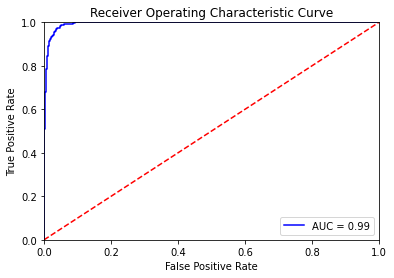

In [33]:
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_clf_test,y_test_clf_proba)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots()

ax.set_title('Receiver Operating Characteristic Curve')
ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
